# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=135f3350b28fb1edb57c4e236c4463d6dde67adbc91026c4b7f1fd41ae166607
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=53e9e52ba90cf01bff65ad4589ec757711de33130e43fd6d5d2997ea3e35757d
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

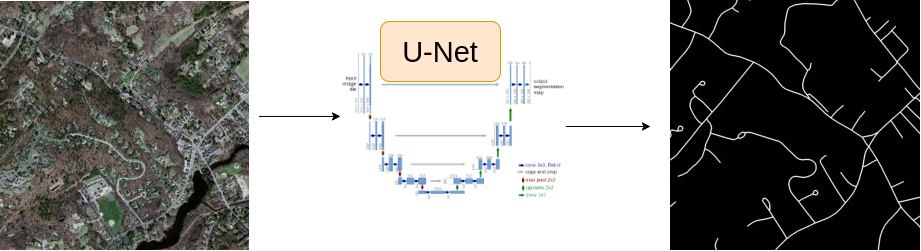

# Download Subset Dataset

---



---



In [3]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 44.69 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [4]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [5]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [6]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [10]:
idx = 17
row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

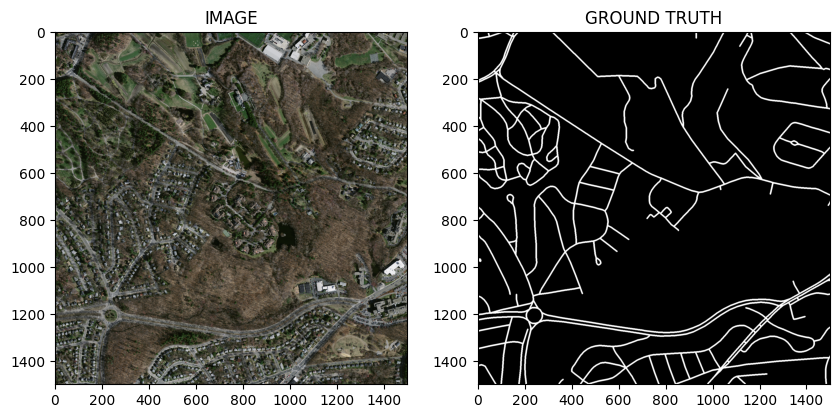

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [52]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

In [53]:
print(len(valid_df))
print(len(train_df))

40
159


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [15]:
import albumentations as A

In [54]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [55]:
from torch.utils.data import Dataset

In [74]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # (h, w)
    mask = np.expand_dims(mask, axis=-1)  # (h, w, c)

    if self.augmentations:
        data = self.augmentations(image=image, mask=mask)
        image = data['image']
        mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # (c, h, w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)  # (c, h, w)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [75]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [76]:
print(f'Size of trainset: {len(trainset)}')
print(f'Size of validset: {len(validset)}')

Size of trainset: 159
Size of validset: 40


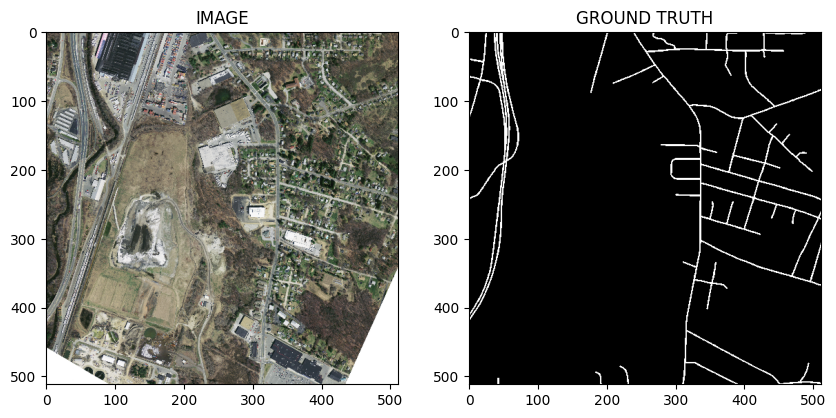

In [78]:
idx = 5
image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [79]:
from torch.utils.data import DataLoader

In [80]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [81]:
print(f'Total no. of batches in trainloader: {len(trainloader)} and in validloader: {len(validloader)}')

Total no. of batches in trainloader: 20 and in validloader: 5


In [82]:
for images, masks in trainloader:
  print(f'One batch image shape: {images.shape} and mask shape: {masks.shape}')
  break

One batch image shape: torch.Size([8, 3, 512, 512]) and mask shape: torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [83]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [92]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [93]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Task 7 : Create Train and Validation Function

In [94]:
def train_fn(dataloader, model, optimizer):
  model.train() # turn on dropout, batchnorm etc...
  total_loss = 0.0

  for images, masks in tqdm(dataloader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)

In [95]:
def eval_fn(dataloader, model):
  model.eval() # turn off dropout, batchnorm etc...
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()

    return total_loss / len(dataloader)

# Task 8 : Train Model

In [96]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [97]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_loss = valid_loss

  print(f'Epoch : {i+1} Train Loss: {train_loss}, Valid Loss: {valid_loss}')

100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


SAVED MODEL
Epoch : 1 Train Loss: 1.122213551402092, Valid Loss: 1.3058838367462158


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


SAVED MODEL
Epoch : 2 Train Loss: 0.7816014885902405, Valid Loss: 0.8128753423690795


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


SAVED MODEL
Epoch : 3 Train Loss: 0.7190496683120727, Valid Loss: 0.7569047451019287


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


SAVED MODEL
Epoch : 4 Train Loss: 0.6909506112337113, Valid Loss: 0.736362898349762


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch : 5 Train Loss: 0.6693635642528534, Valid Loss: 0.7646223068237304


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


SAVED MODEL
Epoch : 6 Train Loss: 0.6547179996967316, Valid Loss: 0.677576768398285


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


SAVED MODEL
Epoch : 7 Train Loss: 0.6434846550226212, Valid Loss: 0.6718251705169678


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch : 8 Train Loss: 0.6381279557943345, Valid Loss: 0.6991326689720154


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


SAVED MODEL
Epoch : 9 Train Loss: 0.6279194802045822, Valid Loss: 0.6657195210456848


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch : 10 Train Loss: 0.6345329284667969, Valid Loss: 0.6720743656158448


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch : 11 Train Loss: 0.6127527713775635, Valid Loss: 0.6715126991271972


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


SAVED MODEL
Epoch : 12 Train Loss: 0.607712784409523, Valid Loss: 0.6523179650306702


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch : 13 Train Loss: 0.6120457381010056, Valid Loss: 0.67863529920578


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch : 14 Train Loss: 0.6162713319063187, Valid Loss: 0.657000207901001


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


SAVED MODEL
Epoch : 15 Train Loss: 0.5984719932079315, Valid Loss: 0.6283401608467102


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch : 16 Train Loss: 0.5824899107217789, Valid Loss: 0.6718668699264526


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch : 17 Train Loss: 0.591574203968048, Valid Loss: 0.6420286655426025


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch : 18 Train Loss: 0.5878823161125183, Valid Loss: 0.6483682274818421


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch : 19 Train Loss: 0.5807132512331009, Valid Loss: 0.6986240386962891


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch : 20 Train Loss: 0.5767170742154122, Valid Loss: 0.7160262703895569


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch : 21 Train Loss: 0.5726492315530777, Valid Loss: 0.6432904481887818


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


SAVED MODEL
Epoch : 22 Train Loss: 0.5746283531188965, Valid Loss: 0.6138699650764465


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch : 23 Train Loss: 0.5801688715815544, Valid Loss: 0.6516650319099426


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch : 24 Train Loss: 0.56844722032547, Valid Loss: 0.6337507605552674


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

Epoch : 25 Train Loss: 0.5591810405254364, Valid Loss: 0.6367578864097595


# Task 9 : Inference

In [98]:
idx = 17

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) -> (b, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

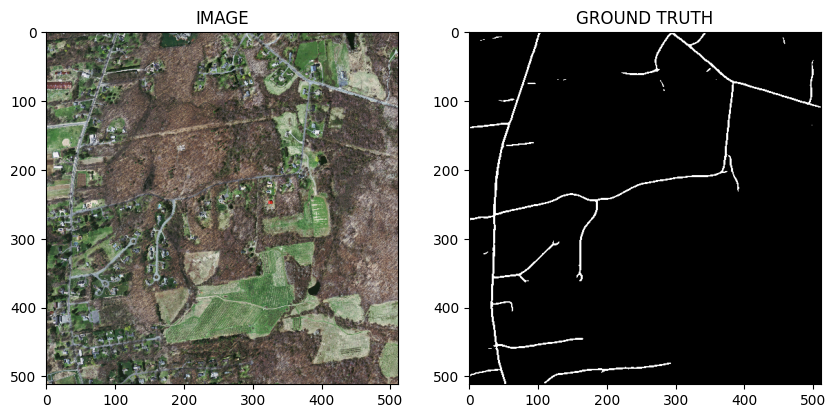

In [99]:
helper.show_image(image, pred_mask.detach().cpu().squeeze(0))